In [ ]:
from google.colab import files
uploaded = files.upload()

Saving export_day.csv to export_day.csv


/tmp/ipython-input-2-3035153298.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["#Date"], dayfirst=True)



🔌 Inverter 0
MAE: 1863.6187699316627


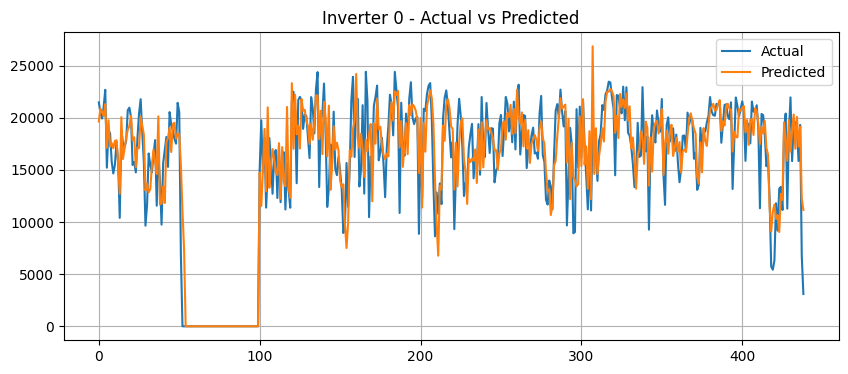

📅 Predicted next-day production (Inv 0): 11415.93 Wh

🔌 Inverter 1
MAE: 540.3124373576309


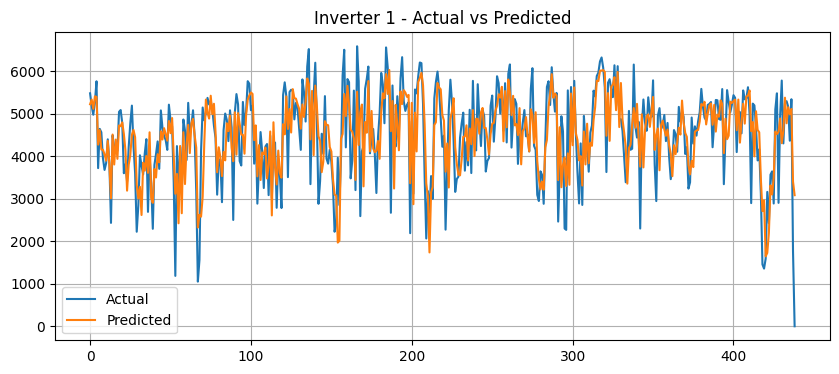

📅 Predicted next-day production (Inv 1): 3009.00 Wh


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load CSV
df = pd.read_csv("export_day.csv", sep=";")
df["Date"] = pd.to_datetime(df["#Date"], dayfirst=True)
df["Psum"] = df["Psum"].astype(float)
df["Pmax"] = df["Pmax"].astype(float)

# Separate by inverter
df_inv0 = df[df["Inv"] == 0].copy()
df_inv1 = df[df["Inv"] == 1].copy()

# Feature engineering
for d in [df_inv0, df_inv1]:
    d["Day"] = d["Date"].dt.day
    d["Month"] = d["Date"].dt.month
    d["Weekday"] = d["Date"].dt.weekday
    d["Prev_Psum"] = d["Psum"].shift(1)
    d["Rolling3"] = d["Psum"].rolling(window=3).mean()

df_inv0.dropna(inplace=True)
df_inv1.dropna(inplace=True)

features = ["Day", "Month", "Weekday", "Prev_Psum", "Rolling3"]
target = "Psum"

def train_and_predict(df, inverter_name):
    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"\n🔌 Inverter {inverter_name}")
    print("MAE:", mean_absolute_error(y_test, y_pred))

    plt.figure(figsize=(10, 4))
    plt.plot(y_test.values, label="Actual")
    plt.plot(y_pred, label="Predicted")
    plt.title(f"Inverter {inverter_name} - Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()

    last_row = df.iloc[-1]
    next_day = pd.DataFrame([{
        "Day": last_row["Date"].day + 1,
        "Month": last_row["Date"].month,
        "Weekday": (last_row["Date"].weekday() + 1) % 7,
        "Prev_Psum": last_row["Psum"],
        "Rolling3": df["Psum"].tail(3).mean()
    }])

    prediction = model.predict(next_day)[0]
    print(f"📅 Predicted next-day production (Inv {inverter_name}): {prediction:.2f} Wh")

train_and_predict(df_inv0, 0)
train_and_predict(df_inv1, 1)


/tmp/ipython-input-4-3007268995.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["#Date"], dayfirst=True)



🔌 Inverter 0
MAE: 1863.6187699316627


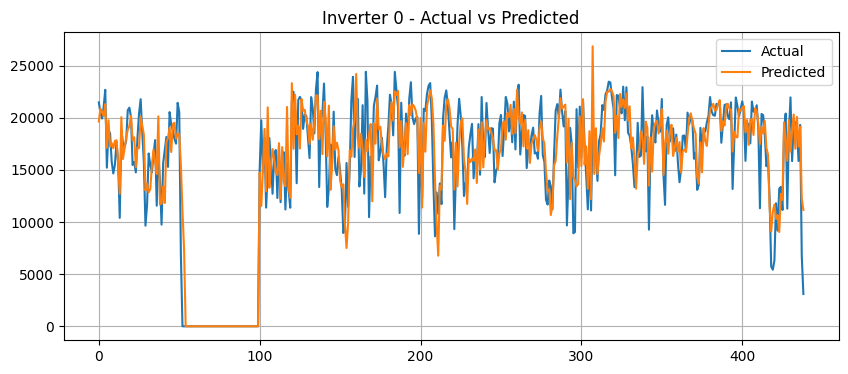


🔌 Inverter 1
MAE: 540.3124373576309


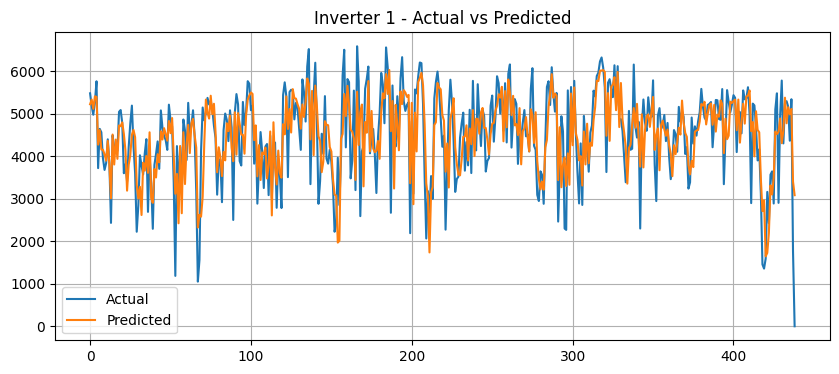

/tmp/ipython-input-4-3007268995.py:104: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


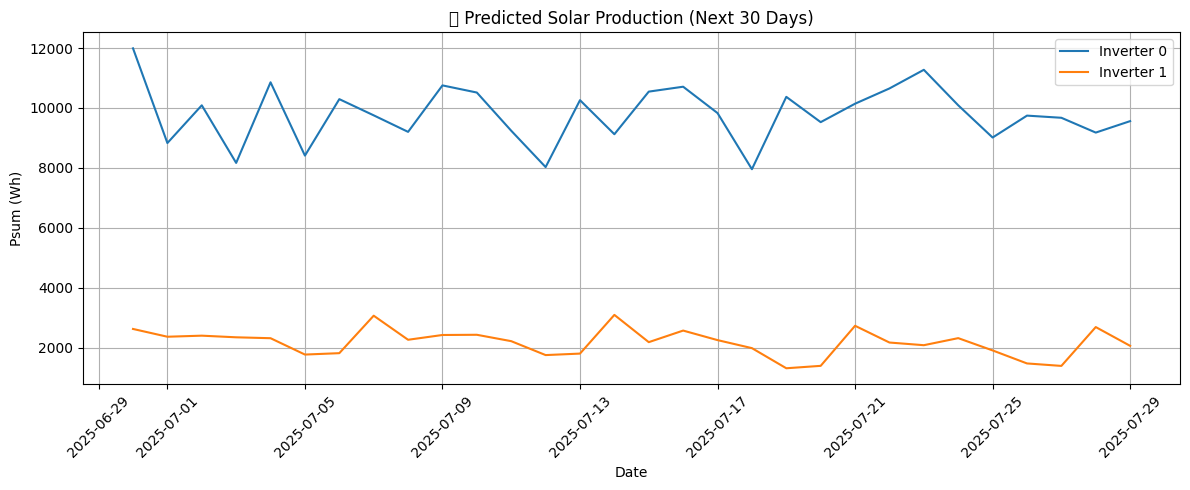

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load CSV
df = pd.read_csv("export_day.csv", sep=";")
df["Date"] = pd.to_datetime(df["#Date"], dayfirst=True)
df["Psum"] = df["Psum"].astype(float)
df["Pmax"] = df["Pmax"].astype(float)

# Separate by inverter
df_inv0 = df[df["Inv"] == 0].copy()
df_inv1 = df[df["Inv"] == 1].copy()

# Feature engineering
for d in [df_inv0, df_inv1]:
    d["Day"] = d["Date"].dt.day
    d["Month"] = d["Date"].dt.month
    d["Weekday"] = d["Date"].dt.weekday
    d["Prev_Psum"] = d["Psum"].shift(1)
    d["Rolling3"] = d["Psum"].rolling(window=3).mean()

df_inv0.dropna(inplace=True)
df_inv1.dropna(inplace=True)

features = ["Day", "Month", "Weekday", "Prev_Psum", "Rolling3"]
target = "Psum"

def train_and_predict(df, inverter_name):
    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"\n🔌 Inverter {inverter_name}")
    print("MAE:", mean_absolute_error(y_test, y_pred))

    plt.figure(figsize=(10, 4))
    plt.plot(y_test.values, label="Actual")
    plt.plot(y_pred, label="Predicted")
    plt.title(f"Inverter {inverter_name} - Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model

def predict_future(df, model, inverter_name, days=30):
    last_date = df["Date"].max()
    recent_psums = list(df["Psum"].tail(3))
    future_predictions = []

    for i in range(days):
        next_date = last_date + pd.Timedelta(days=1)
        weekday = next_date.weekday()

        next_features = {
            "Day": next_date.day,
            "Month": next_date.month,
            "Weekday": weekday,
            "Prev_Psum": recent_psums[-1],
            "Rolling3": sum(recent_psums[-3:]) / 3,
        }

        next_df = pd.DataFrame([next_features])
        prediction = model.predict(next_df)[0]

        future_predictions.append({
            "Date": next_date,
            "Predicted_Psum": prediction
        })

        recent_psums.append(prediction)
        last_date = next_date

    return pd.DataFrame(future_predictions)

# Train models and forecast
model_inv0 = train_and_predict(df_inv0, 0)
model_inv1 = train_and_predict(df_inv1, 1)

future_inv0 = predict_future(df_inv0, model_inv0, inverter_name=0)
future_inv1 = predict_future(df_inv1, model_inv1, inverter_name=1)

# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(future_inv0["Date"], future_inv0["Predicted_Psum"], label="Inverter 0")
plt.plot(future_inv1["Date"], future_inv1["Predicted_Psum"], label="Inverter 1")
plt.title("📅 Predicted Solar Production (Next 30 Days)")
plt.ylabel("Psum (Wh)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# prompt: explain the above graps in numbers

# Calculate and print summary statistics for the predicted future dataframes
print("\n📊 Predicted Solar Production (Next 30 Days) - Summary:")
print("\nInverter 0:")
print(future_inv0.describe())

print("\nInverter 1:")
print(future_inv1.describe())

print("\nCombined Prediction:")
print(
    (future_inv0["Predicted_Psum"] + future_inv1["Predicted_Psum"])
    .describe()
)


📊 Predicted Solar Production (Next 30 Days) - Summary:

Inverter 0:
                      Date  Predicted_Psum
count                   30       30.000000
mean   2025-07-14 12:00:00     9792.680000
min    2025-06-30 00:00:00     7957.170000
25%    2025-07-07 06:00:00     9184.822500
50%    2025-07-14 12:00:00     9791.870000
75%    2025-07-21 18:00:00    10478.667500
max    2025-07-29 00:00:00    11989.490000
std                    NaN      965.377386

Inverter 1:
                      Date  Predicted_Psum
count                   30       30.000000
mean   2025-07-14 12:00:00     2177.424000
min    2025-06-30 00:00:00     1317.000000
25%    2025-07-07 06:00:00     1843.245000
50%    2025-07-14 12:00:00     2238.340000
75%    2025-07-21 18:00:00     2421.122500
max    2025-07-29 00:00:00     3097.460000
std                    NaN      457.227586

Combined Prediction:
count       30.000000
mean     11970.104000
std       1129.881471
min       9784.260000
25%      11204.825000
50%      120

In [ ]:
# prompt: export the above results to csv

# Combine the future predictions into a single DataFrame
future_combined = future_inv0.rename(columns={'Predicted_Psum': 'Predicted_Psum_Inv0'}).set_index('Date')
future_combined['Predicted_Psum_Inv1'] = future_inv1.set_index('Date')['Predicted_Psum']

# Calculate the total predicted Psum
future_combined['Predicted_Psum_Total'] = future_combined['Predicted_Psum_Inv0'] + future_combined['Predicted_Psum_Inv1']

# Export the combined future predictions to a CSV file
future_combined.to_csv('future_solar_production.csv')

# Optionally download the file
files.download('future_solar_production.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>